In [40]:
import pandas as pd
import numpy as np
import json
# plotting
import os
import pathlib
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mplsoccer import Pitch
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Get the data

In [41]:
notebook_dir = pathlib.Path().absolute()
events_path = os.path.join(notebook_dir.parent, "wyscout-data", "events", "events_England.json")

with open(events_path) as f:
    events = json.load(f)

df = pd.DataFrame(events)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643150 entries, 0 to 643149
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       643150 non-null  int64  
 1   subEventName  643150 non-null  object 
 2   tags          643150 non-null  object 
 3   playerId      643150 non-null  int64  
 4   positions     643150 non-null  object 
 5   matchId       643150 non-null  int64  
 6   eventName     643150 non-null  object 
 7   teamId        643150 non-null  int64  
 8   matchPeriod   643150 non-null  object 
 9   eventSec      643150 non-null  float64
 10  subEventId    643150 non-null  object 
 11  id            643150 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 58.9+ MB


# Preparing the data

In [42]:
# Get at next event
next_event = df.shift(-1, fill_value=0)

# Set nextEvent and kickedOut
df["nextEvent"] = next_event["subEventName"]
df["kickedOut"] = df.apply(lambda x: 1 if x["nextEvent"] == "Ball out of the field" else 0, axis=1)

# Drop interruptions
interruptions = df[df["eventName"] == "Interruption"]
df = df.drop(interruptions.index)

# Drop non-accurate duels (wyscout saves two: attacking and defending)
lost_duels = df[df["eventName"] == "Duel"]
lost_duels = lost_duels[lost_duels.apply(lambda x: {"id": 1802} in x["tags"], axis = 1)]
df = df.drop(lost_duels.index)

# Drop ball out of field
out_of_fields = df[df["subEventName"] == "Ball out of the field"]
df = df.drop(out_of_fields.index)

# Drop save attempts
save_attempts = df[df["subEventName"].isin(["Goalkeeper leaving line", "Save attempt", "Reflexes"])]
df = df.drop(save_attempts.index)

df.shape

(542524, 14)

# Isolating possession chains

In [43]:
def isolateChains(df):
    """
    Takes a dataframe with Wyscout event data.

    Returns a dataframe with isolated possesion chains

    """
    # Add new column with team id's of the next event
    df["nextTeamId"] = df.shift(-1, fill_value=0)["teamId"]

    # Init variables
    chain = 0
    chain_team = df.iloc[0]["teamId"]
    period = df.iloc[0]["matchPeriod"]
    stop_criterion = 0
    df["possession_chain"] = 0
    df["possession_chain_team"] = 0

    for i, row in df.iterrows():
        # Set the chain number and team
        df.at[i, "possession_chain"] = chain
        df.at[i, "possession_chain_team"] = chain_team

        # If pass is not accurate or it's a lost duel, add 1 to stop criterion
        if row["eventName"] == "Pass" or row["eventName"] == "Duel":
            if row["teamId"] == chain_team and {"id": 1802} in row["tags"]:
                    stop_criterion += 1
            if row["teamId"] != chain_team and {"id": 1801} in row["tags"]:
                    stop_criterion += 1

        # If ball is intercepted properly, add 2 to stop criterion
        if row["eventName"] == "Others on the ball":
            if row["teamId"] == row["nextTeamId"]:
                stop_criterion += 2

        # If actions is over thanks to a shot, foul or offside: add 2 to stop criterion
        if row["eventName"] in ["Shot", "Foul", "Offside"]:
            stop_criterion += 2

        # If ball is out of field, add 2 to stop criterion
        if row["kickedOut"] == 1:
            stop_criterion += 2
            
        # If period ended, reset variables
        if row["matchPeriod"] != period:
            chain += 1
            stop_criterion = 0
            chain_team = row['teamId']
            period = row["matchPeriod"]
            df.at[i, "possession_chain"] = chain
            df.at[i, "possession_chain_team"] = chain_team

        # If stop criterion is 2 or more, add 1 to chain number and reset stop criterion
        if stop_criterion >= 2:
            chain += 1
            stop_criterion = 0
            chain_team = row['nextTeamId']

    return df

df = isolateChains(df)

In [44]:
# Check a chain
df[df["possession_chain"] == 4][["eventName", "possession_chain"]]

,eventName,possession_chain
36,Free Kick,4
37,Pass,4
38,Duel,4
40,Duel,4
42,Pass,4
43,Pass,4
44,Pass,4
45,Pass,4
46,Shot,4


# Calculating xG value

In [45]:
def calculatexG(df):
    """
    Takes a df with wyscout event data
    Returns a df with xG added for each shot
    """

    # Get shots for xG model
    shots = df[df["eventName"] == "Shot"].copy()

    # Prepare coordinates for model
    shots["X"] = shots["positions"].apply(lambda cell: (100 - cell[0]["x"]) * 105/100)
    shots["Y"] = shots["positions"].apply(lambda cell: cell[0]["y"] * 68/100)
    shots["C"] = shots["positions"].apply(lambda cell: abs(50 - cell[0]["y"]) * 68/100)

    # Feature engineering for model
    shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
    shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
    shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)

    # Split goals between headers and non headers
    headers = shots.loc[shots.apply (lambda x:{'id':403} in x.tags, axis = 1)]
    non_headers = shots.drop(headers.index)

    # Model for headers
    headers_model = smf.glm(formula="Goal ~ Distance + Angle" , data=headers, family=sm.families.Binomial()).fit()

    # Model for non headers
    nonheaders_model = smf.glm(formula="Goal ~ Distance + Angle" , data=non_headers, family=sm.families.Binomial()).fit()

    # Init xG column
    df["xG"] = 0

    # set xG for headers
    b_head = headers_model.params
    xG = 1/(1+np.exp(b_head[0]+b_head[1]*headers['Distance'] + b_head[2]*headers['Angle']))
    headers = headers.assign(xG = xG)

    # Add values to original df
    for index, row in headers.iterrows():
        df.at[index, "xG"] = row["xG"]


    # Set xG for non headers
    b_nhead = nonheaders_model.params
    xG = 1/(1+np.exp(b_nhead[0]+b_nhead[1]*non_headers['Distance'] + b_nhead[2]*non_headers['Angle']))
    non_headers = non_headers.assign(xG = xG)

    # Add values to original df
    for index, row in non_headers.iterrows():
        df.at[index, "xG"] = row["xG"]

    # Get penalties
    penalties = df[df["eventName"] == "Penalty"]

    # Treat penalties as shots
    penalties["X"] = 11
    penalties["Distance"] = 11
    penalties["Angle"] = np.arctan(7.32 * 11 /(11**2 - (7.32/2)**2))
    penalties["Goal"] = penalties.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
    penalties = penalties.assign(xG = xG)
    for index, row in penalties.iterrows():
        df.at[index, "xG"] = row["xG"]
    
    
    return df

df = calculatexG(df)

In [50]:
df.loc[df["possession_chain"].isin([3,4])][["eventName", "possession_chain", "xG"]]

,eventName,possession_chain,xG
25,Pass,3,0.000000
26,Pass,3,0.000000
27,Duel,3,0.000000
30,Duel,3,0.000000
31,Duel,3,0.000000
34,Duel,3,0.000000
35,Foul,3,0.000000
36,Free Kick,4,0.000000
37,Pass,4,0.000000
38,Duel,4,0.000000


# Finding chains ending in a shot

In [51]:
def prepareChains(df):
    """
    Takes a df with wyscout event data
    Returns a df where the whole chains get the xG of the shot (if there was one)
    """

    # Init shot_end column
    df["shot_end"] = 0

    # Get number of chains for loop
    no_chains = max(df["possession_chain"].unique())
    indicies = []

    # Loop through chains
    for i in range(no_chains + 1):
        # Get events in chain
        possession_chain_df = df[df["possession_chain"] == i]

        # Check if chain is not empty
        if len(possession_chain_df) > 0:
            # Check if chain ends in a shot
            if possession_chain_df.iloc[-1]["eventName"] == "Shot":
                # Set shot_end to 1
                df.loc[possession_chain_df.index, "shot_end"] = 1
                
                # Get xG of shot
                xG = possession_chain_df.iloc[-1]["xG"]

                # Assign xG to all events in chain
                df.loc[possession_chain_df.index, "xG"] = xG

                # Check if previous chain ended in a foul (xG of this chain should also be added to that one)
                k = i - 1
                if k > 0:
                    try:
                        prev_chain = df[df["possession_chain"] == k]
                        # Loop through all previous chains that ended in a foul
                        while prev_chain.iloc[-1]["eventName"] == "Foul":
                            df.loc[df["possession_chain"] == k, "xG"] = xG
                            df.loc[df["possession_chain"] == k, "shot_end"] = 1
                            k -= 1
                            prev_chain = df[df["possession_chain"] == k]
                    except:
                        k -= 1
        
            # Get indicies of events made by possession team
            team_indicies = possession_chain_df[possession_chain_df["teamId"] == possession_chain_df.teamId.mode().iloc[0]].index.values.tolist()

            # Add indicies to list
            indicies.extend(team_indicies)

    # Filter df on indicies so that we only keep actions when a team had possession
    df = df.loc[indicies]

    return df

df = prepareChains(df)

In [53]:
df.loc[df["possession_chain"].isin([3,4])][["eventName", "possession_chain", "xG", "shot_end"]]

,eventName,possession_chain,xG,shot_end
25,Pass,3,0.137573,1
26,Pass,3,0.137573,1
30,Duel,3,0.137573,1
31,Duel,3,0.137573,1
34,Duel,3,0.137573,1
36,Free Kick,4,0.137573,1
37,Pass,4,0.137573,1
38,Duel,4,0.137573,1
40,Duel,4,0.137573,1
42,Pass,4,0.137573,1


# Prepare data for modelling

- Filtering out events without end coordinates
- Store coordinates in seperate columns
- Create c-variable (distance to horizontal line through the middle of the pitch)
- Set end of shot coordinates to (105, 34)

In [54]:
# Filter out events without end coordinates
df = df[df.apply(lambda x: len(x["positions"]) == 2, axis = 1)]

# Store coordinates in seperate columns
df["x0"] = df["positions"].apply(lambda cell: (cell[0]["x"]) * 105/100)
df["x1"] = df["positions"].apply(lambda cell: (cell[1]["x"]) * 105/100)
df["c0"] = df["positions"].apply(lambda cell: abs(50 - cell[0]["y"]) * 68/100)
df["c1"] = df["positions"].apply(lambda cell: abs(50 - cell[1]["y"]) * 68/100)

# Assing correct coordinates to shot events
df.loc[df["eventName"] == "Shot", "x1"] = 105
df.loc[df["eventName"] == "Shot", "c1"] = 0

# Set y coordinates (only used for plotting)
df["y0"] = df["positions"].apply(lambda cell: (100 - cell[0]["y"]) * 68/100)
df["y1"] = df["positions"].apply(lambda cell: (100 - cell[1]["y"]) * 68/100)
df.loc[df["eventName"] == "Shot", "y1"] = 34

df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,possession_chain,possession_chain_team,xG,shot_end,x0,x1,c0,c1,y0,y1
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,0,1609,0.0,0,51.45,32.55,0.68,19.04,34.68,14.96
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,...,0,1609,0.0,0,32.55,53.55,19.04,17.00,14.96,17.00
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,...,0,1609,0.0,0,53.55,36.75,17.00,14.28,17.00,19.72
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,...,0,1609,0.0,0,36.75,43.05,14.28,30.60,19.72,3.40
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,...,0,1609,0.0,0,43.05,75.60,30.60,25.84,3.40,8.16


# Plot a possession chain

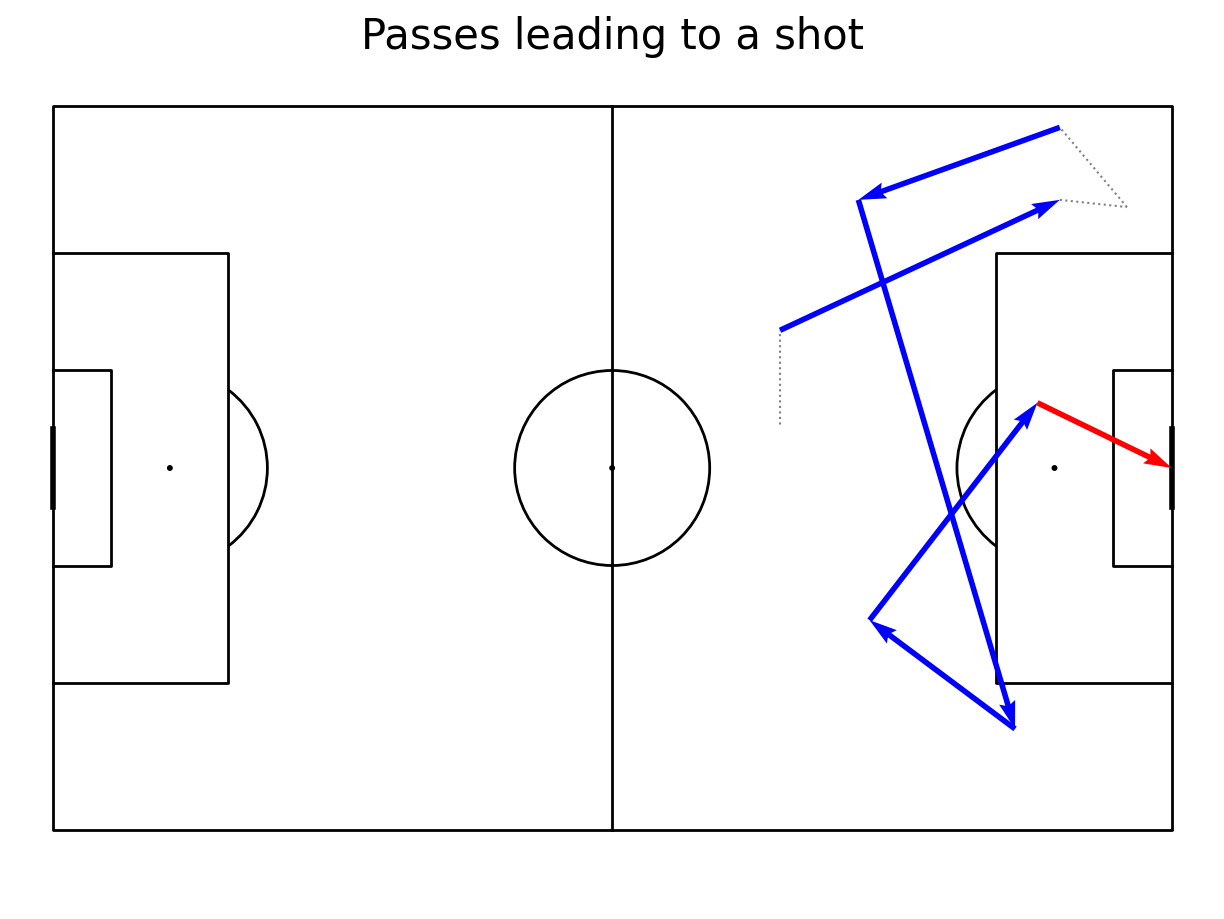

In [55]:
# Get chain
chain = df[df["possession_chain"] == 4]

# Split passes and other events
passes = chain[chain["eventName"] == "Pass"]
not_passes = chain[chain["eventName"] != "Pass"]

# Get shot (is the last event in chain)
shot = chain.iloc[-1]

# Init plot
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Plot passes
pitch.arrows(passes["x0"], passes["y0"], passes["x1"], passes["y1"], ax=ax["pitch"], color="blue", zorder=3)

# Plot shot
pitch.arrows(shot["x0"], shot["y0"], shot["x1"], shot["y1"], ax=ax["pitch"], color="red", zorder=3)

# Plot other events
pitch.lines(not_passes["x0"], not_passes["y0"], not_passes["x1"], not_passes["y1"], ax=ax["pitch"], color="grey", lw=1.5, ls="dotted")

ax['title'].text(0.5, 0.5, 'Passes leading to a shot', ha='center', va='center', fontsize=30)
plt.show()


# Plot possession chain that didn't end in a shot

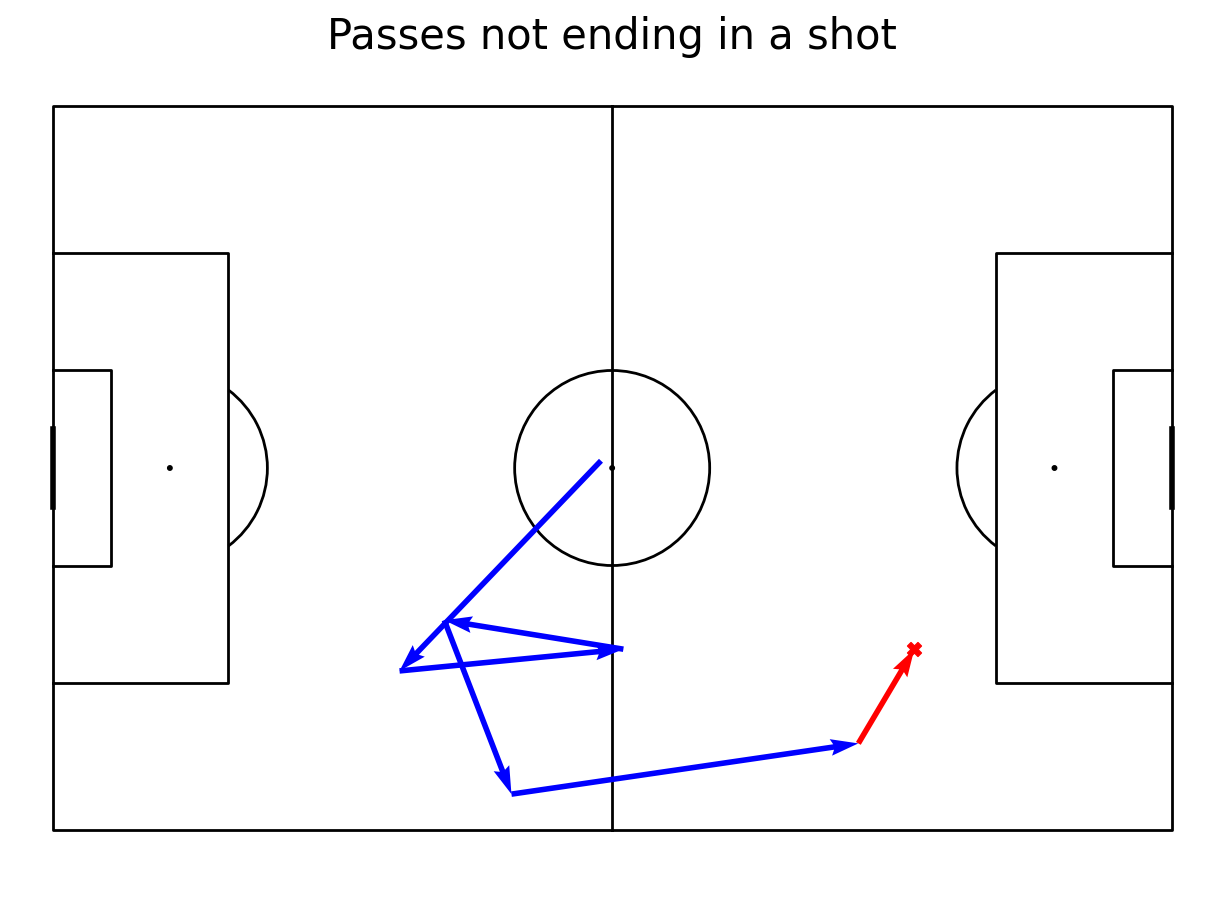

In [56]:
# Get chain
chain = df[df["possession_chain"] == 0]

# Split passes, other events and badd pass
passes = chain.loc[chain["eventName"].isin(["Pass", "Free Kick"])].iloc[:-1]
not_passes = chain.loc[(chain["eventName"] != "Pass") & (chain["eventName"] != "Free Kick")].iloc[:-1]
bad_pass = chain.iloc[-1]

# Init plot and pitch
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Plot passes
pitch.arrows(passes["x0"], passes["y0"], passes["x1"], passes["y1"], ax=ax["pitch"], color="blue", zorder=3)

# Plot bad pass
pitch.arrows(bad_pass["x0"], bad_pass["y0"], bad_pass["x1"], bad_pass["y1"], ax=ax["pitch"], color="red", zorder=3)

# Plot end of chain
pitch.scatter(bad_pass["x1"], bad_pass["y1"], color="red", marker="X", s=100, ax=ax["pitch"], zorder=4)

# Plot other events
pitch.lines(not_passes["x0"], not_passes["y0"], not_passes["x1"], not_passes["y1"], ax=ax["pitch"], color="grey", lw=1.5, ls="dotted")

ax['title'].text(0.5, 0.5, 'Passes not ending in a shot', ha='center', va='center', fontsize=30)
plt.show()